## Reproduce Figure 2b and the upper-right panel of S2
Note that this notebook is RAM-intensive, but can be run on a 16G RAM laptop.

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import random
import os
import Levenshtein
import fastcluster as fc
import scipy.cluster.hierarchy as hier
import pickle
# To allow imports from common directory
sys.path.append('../../')
from common.plot_style_utils import set_pub_plot_context, rep_names, save_for_pub
from common.embedding_tools import lev_dist_matrix, lev_sim_matrix

%matplotlib inline
random.seed(42)
np.random.seed(42)

Compute the mean representation within each organism. Use this to hierarchical cluster organisms, and project the mean organism reps into the PCA basis learned from Surge's 100K uniprot sequences.

In [2]:
meta = pd.DataFrame(np.load("../../data/meta_full_53.npy"))
meta.columns =["id", "seq", "description", "name", "organism"]
meta

,id,seq,description,name,organism
0,sp|Q966C6|RL7A_CAEEL,MPSKKVIKKKVAAVPAHIRAQTQVQKEVKNPLFEKRARNFNIGQDI...,sp|Q966C6|RL7A_CAEEL 60S ribosomal protein L7a...,sp|Q966C6|RL7A_CAEEL,celegans
1,sp|P48162|R23A1_CAEEL,MAPSAPAKTAKALDAKKKVVKGKRTTHRRQVRTSVHFRRPVTLKTA...,sp|P48162|R23A1_CAEEL 60S ribosomal protein L2...,sp|P48162|R23A1_CAEEL,celegans
2,sp|O61790|PYRE_CAEEL,MTAATATANGNHSIEDPVVMKVQAASPIQETDFFENLYQMECFRTG...,sp|O61790|PYRE_CAEEL Orotate phosphoribosyltra...,sp|O61790|PYRE_CAEEL,celegans
3,sp|Q20647|R23A2_CAEEL,MAPSSNKVGKAIQAKKAVVKGSKTNVRKNVRTSVHFRRPKTLVTAR...,sp|Q20647|R23A2_CAEEL 60S ribosomal protein L2...,sp|Q20647|R23A2_CAEEL,celegans
4,sp|Q94986|RAB3_CAEEL,MAAGGQPQGATPGQPDQNFDYMFKLLIIGNSSVGKTSFLFRYCDDS...,sp|Q94986|RAB3_CAEEL Ras-related protein Rab-3...,sp|Q94986|RAB3_CAEEL,celegans
5,sp|Q03206|RAC1_CAEEL,MQAIKCVVVGDGAVGKTCLLISYTTNAFPGEYIPTVFDNYSANVMV...,sp|Q03206|RAC1_CAEEL Ras-related protein ced-1...,sp|Q03206|RAC1_CAEEL,celegans
6,sp|Q18246|RAP1_CAEEL,MREYKIVVLGSGGVGKSALTVQFVQGIFVEKYDPTIEDSYRKQVEV...,sp|Q18246|RAP1_CAEEL Ras-related protein Rap-1...,sp|Q18246|RAP1_CAEEL,celegans
7,sp|O44568|RF1M_CAEEL,MLKRHQQLLFRLIRQSVLHQSSPTSSSASSTLLNSENGEKFVKTVV...,sp|O44568|RF1M_CAEEL Probable peptide chain re...,sp|O44568|RF1M_CAEEL,celegans
8,sp|Q9XWR6|RAB28_CAEEL,MTTMGEDEAPALPKKSPLPEKIDEADVDDDPDDKVIKIVVVGDGAS...,sp|Q9XWR6|RAB28_CAEEL Ras-related protein Rab-...,sp|Q9XWR6|RAB28_CAEEL,celegans
9,sp|Q93538|RB3GP_CAEEL,MAEIEENTVFEINDFTIVTDMEHFGAAFEGILQKYEFSSRRPCLSN...,sp|Q93538|RB3GP_CAEEL Rab3 GTPase-activating p...,sp|Q93538|RB3GP_CAEEL,celegans


In [3]:
reps = np.memmap("../../data/avg_hidden_full_53.memnpy",
                     mode="r",
                     dtype=np.float32,
                     shape=(899329, 1900)
                     )
reps

memmap([[ 0.00409179, -0.02905684,  0.05819068, ..., -0.00640377,
          0.05548698,  0.03035289],
        [ 0.0080851 , -0.00502201,  0.04631828, ..., -0.00594639,
          0.09829481, -0.00456978],
        [ 0.00619606,  0.12493809,  0.13175243, ...,  0.08588191,
         -0.01561721,  0.07642487],
        ..., 
        [ 0.01399851, -0.01622907,  0.04078233, ...,  0.05040194,
         -0.02433978, -0.0183096 ],
        [ 0.00190381, -0.01524683,  0.04347293, ...,  0.03419648,
          0.12348282,  0.00227409],
        [ 0.00615512, -0.09486897,  0.09610456, ..., -0.02209055,
         -0.00786154, -0.05638368]], dtype=float32)

In [4]:
organisms = meta.organism.unique().tolist()
organisms

['celegans',
 'drosophila',
 'ecoliK12',
 'human',
 'mouse',
 'yeast',
 'afischeri',
 'anolis_carolinensis',
 'aspergillus_nidulans',
 'athaliana',
 'azotobacter_vinelandii',
 'bsubtilis168',
 'cavia_porcellus',
 'chicken',
 'coprinopsis_cinerea',
 'cow',
 'creinhardtii',
 'cryptococcus_neoformans',
 'cyanothecePCC7822',
 'dog',
 'ehuxleyi',
 'halobacterium_salinarum',
 'haloferax_volcanii',
 'macaca_mulatta',
 'maize',
 'methanococcus_maripaludis',
 'methanosarcina_acetivorans',
 'mgenitalium',
 'mtuberculosis',
 'naked_molerat',
 'neurospora_crassa',
 'oryzias_latipes',
 'phage_lambda',
 'physcomitrella_patens',
 'pigeon',
 'pig_sus_scrofa',
 'pristionchus_pacificus',
 'prochlorococcus_marinus',
 'rice_japonica',
 'spombe',
 'streptomyces_coelicolor_A32',
 'sulfolobus_solfataricus',
 'SV40',
 'synechocystis_PCC_6803_Kazusa',
 't4_phage',
 't7_phage',
 'tetrahymena_thermophila',
 'thermococcus_kodakarensis',
 'tpseudonana',
 'ustilago_maydis',
 'vaccinia_virus_copenhagen',
 'xenopus_t

In [5]:
organism_means = pd.DataFrame({
    "organism":organisms,
    "mean_rep":[np.mean(
                        reps[meta.organism == o],
                        axis=0
                       ) for o in organisms]
}
).set_index("organism")
organism_means

,mean_rep
organism,
celegans,"[0.009305, -0.0249642, 0.0590213, -0.0130596, ..."
drosophila,"[0.00918944, -0.0239516, 0.0533341, -0.0150933..."
ecoliK12,"[0.0118437, 0.0272404, 0.0827112, -0.034288, -..."
human,"[0.0130582, -0.0374107, 0.0428389, -0.00578527..."
mouse,"[0.0147409, -0.0370224, 0.0479789, -0.00780742..."
yeast,"[0.00771811, -0.00860357, 0.0627896, -0.016818..."
afischeri,"[0.009797, 0.0214618, 0.0934022, -0.0330262, -..."
anolis_carolinensis,"[0.0106315, -0.0293022, 0.0575636, -0.0130022,..."
aspergillus_nidulans,"[0.0098239, 0.00559143, 0.0596446, -0.016902, ..."


In [6]:
def label_point(x, y, val, ax, fontsize=20):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']),
               fontsize=fontsize)

In [7]:
# Now lets try TSNE
tsne = TSNE(n_components=2, perplexity=12, random_state=42)
components = tsne.fit_transform(organism_means.mean_rep.tolist())

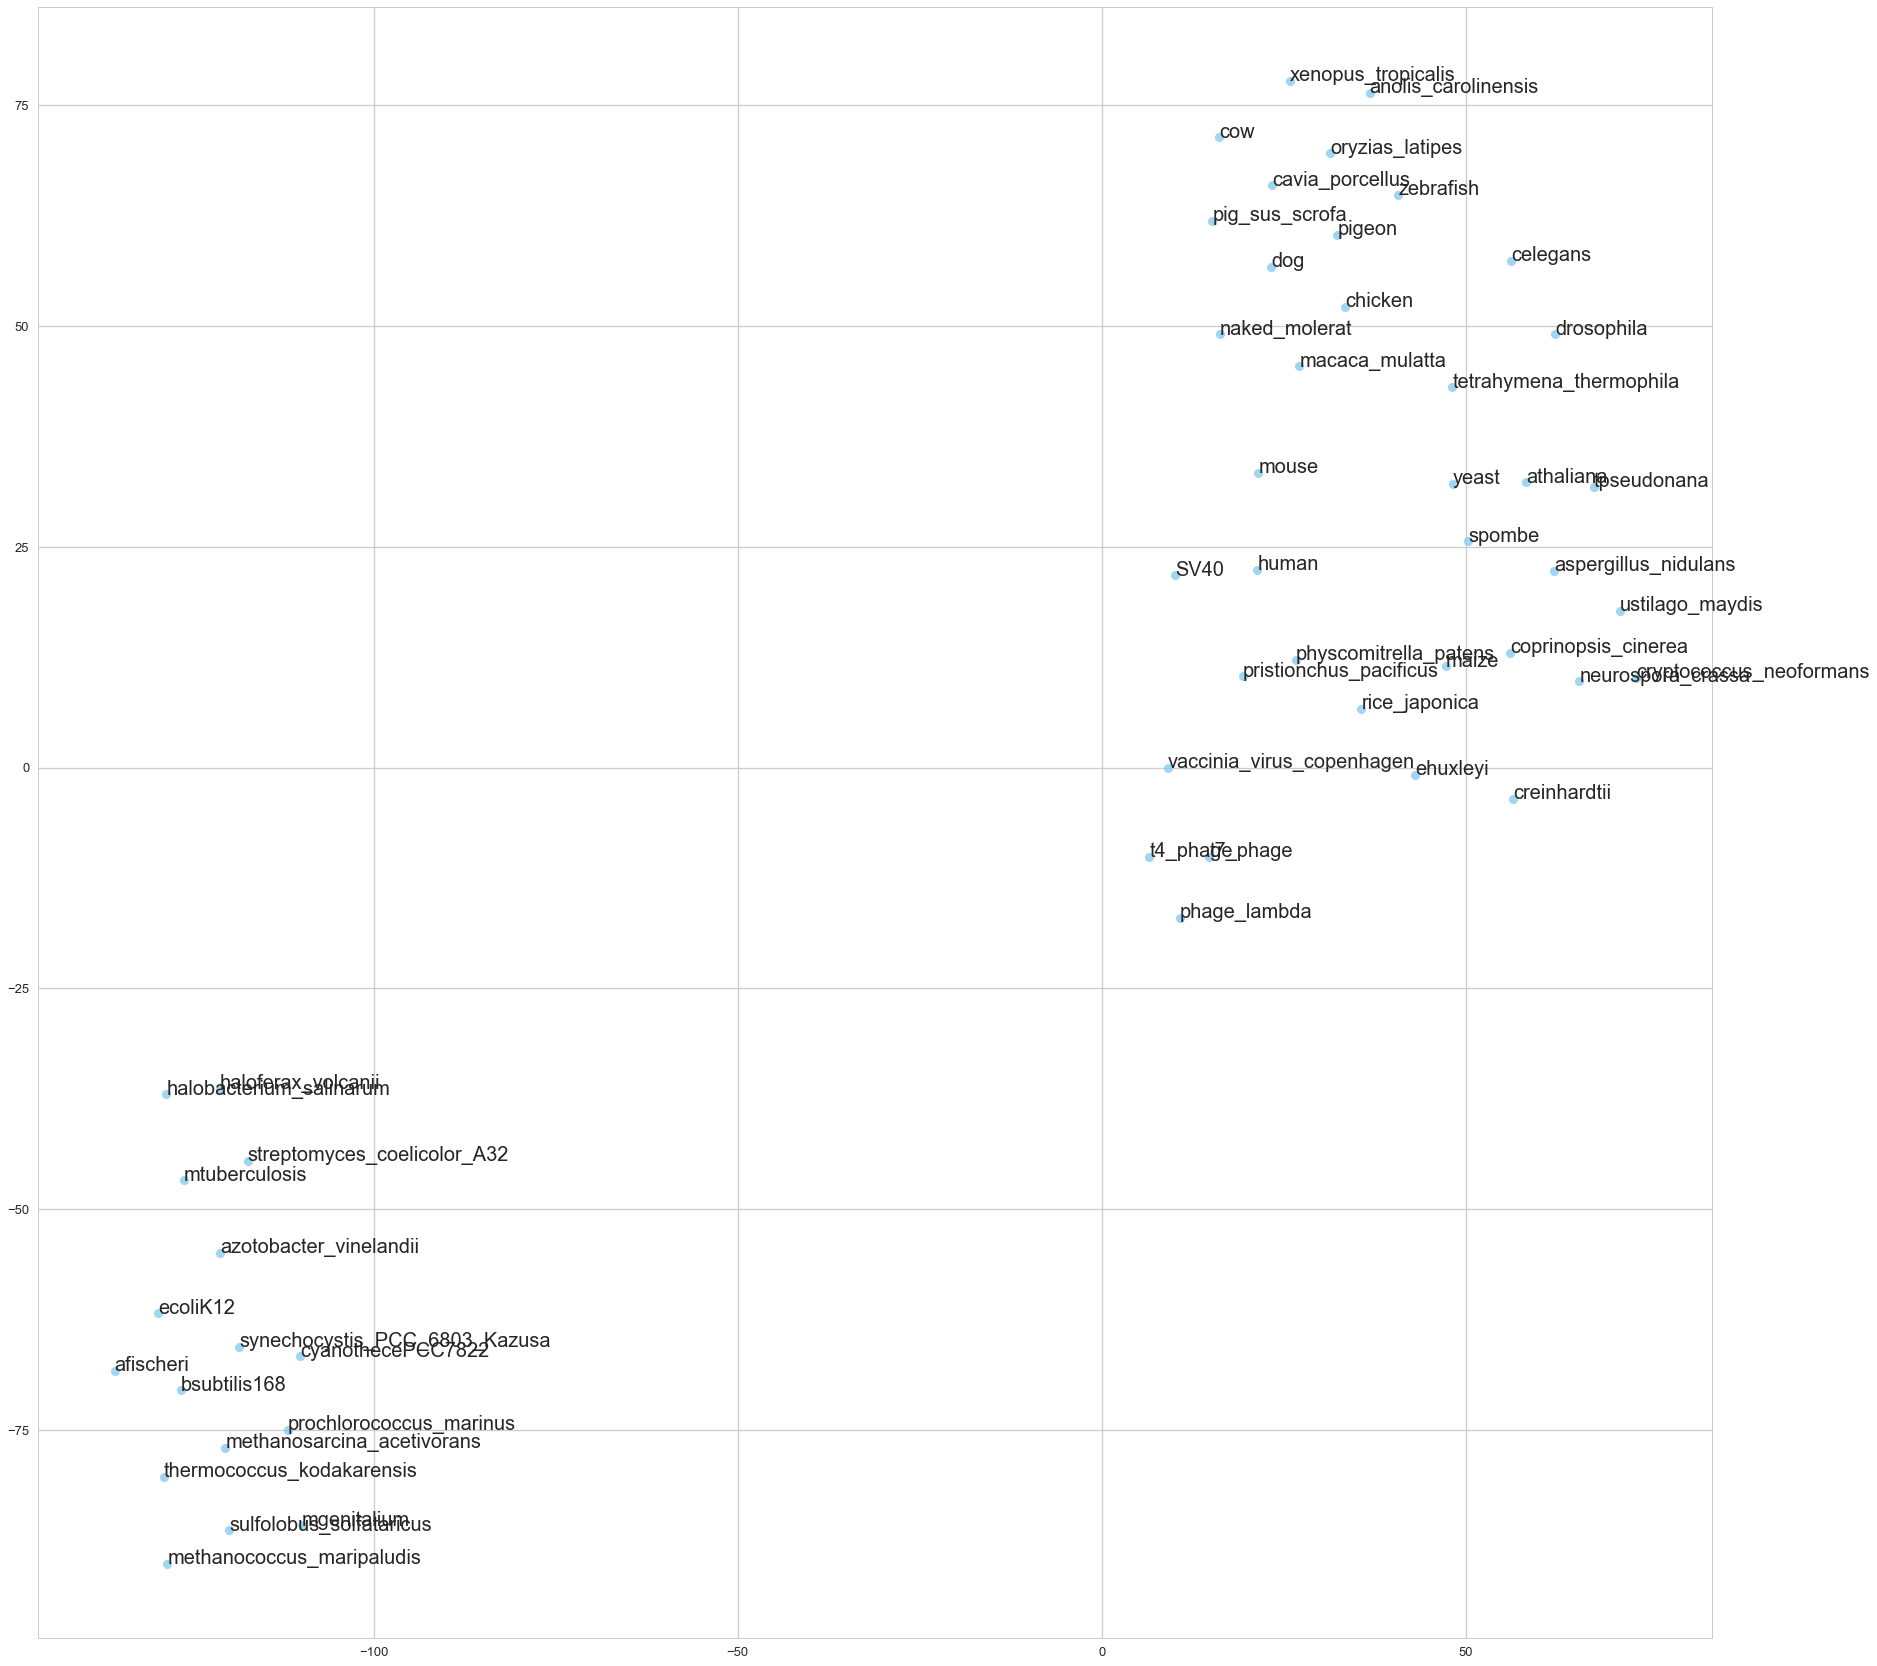

In [8]:
set_pub_plot_context()
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
x = components[:,0]
y = components[:,1]
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
label_point(pd.Series(x),pd.Series(y),
            pd.Series(organism_means.index.values)
            ,ax, fontsize=20)

In [9]:
organism_means.index.values

array(['celegans', 'drosophila', 'ecoliK12', 'human', 'mouse', 'yeast',
       'afischeri', 'anolis_carolinensis', 'aspergillus_nidulans',
       'athaliana', 'azotobacter_vinelandii', 'bsubtilis168',
       'cavia_porcellus', 'chicken', 'coprinopsis_cinerea', 'cow',
       'creinhardtii', 'cryptococcus_neoformans', 'cyanothecePCC7822',
       'dog', 'ehuxleyi', 'halobacterium_salinarum', 'haloferax_volcanii',
       'macaca_mulatta', 'maize', 'methanococcus_maripaludis',
       'methanosarcina_acetivorans', 'mgenitalium', 'mtuberculosis',
       'naked_molerat', 'neurospora_crassa', 'oryzias_latipes',
       'phage_lambda', 'physcomitrella_patens', 'pigeon', 'pig_sus_scrofa',
       'pristionchus_pacificus', 'prochlorococcus_marinus',
       'rice_japonica', 'spombe', 'streptomyces_coelicolor_A32',
       'sulfolobus_solfataricus', 'SV40', 'synechocystis_PCC_6803_Kazusa',
       't4_phage', 't7_phage', 'tetrahymena_thermophila',
       'thermococcus_kodakarensis', 'tpseudonana', 'usti

In [10]:
domain = {
    'celegans':"Eukarya", 
    'drosophila':"Eukarya", 
    'ecoliK12':"Bacteria", 
    'human':"Eukarya", 
    'mouse':"Eukarya", 
    'yeast':"Eukarya",
    'afischeri':"Bacteria", 
    'anolis_carolinensis':"Eukarya", 
    'aspergillus_nidulans':"Eukarya",
    'athaliana':"Eukarya", 
    'azotobacter_vinelandii':"Bacteria", 
    'bsubtilis168':"Bacteria",
    'cavia_porcellus':"Eukarya", 
    'chicken':"Eukarya", 
    'coprinopsis_cinerea':"Eukarya", 
    'cow':"Eukarya",
    'creinhardtii':"Eukarya", 
    'cryptococcus_neoformans':"Eukarya", 
    'cyanothecePCC7822':"Bacteria",
    'dog':"Eukarya", 
    'ehuxleyi':"Eukarya", 
    'halobacterium_salinarum':"Archaea", 
    'haloferax_volcanii':"Archaea",
    'macaca_mulatta':"Eukarya", 
    'maize':"Eukarya", 
    'methanococcus_maripaludis':"Archaea",
    'methanosarcina_acetivorans':"Archaea", 
    'mgenitalium':"Bacteria", 
    'mtuberculosis':"Bacteria",
    'naked_molerat':"Eukarya", 
    'neurospora_crassa':"Eukarya", 
    'oryzias_latipes':"Eukarya",
    'phage_lambda':"Virus", 
    'physcomitrella_patens':"Eukarya", 
    'pigeon':"Eukarya", 
    'pig_sus_scrofa':"Eukarya",
    'pristionchus_pacificus':"Eukarya", 
    'prochlorococcus_marinus':"Bacteria",
    'rice_japonica':"Eukarya", 
    'spombe':"Eukarya", 
    'streptomyces_coelicolor_A32':"Bacteria",
    'sulfolobus_solfataricus':"Archaea", 
    'SV40':"Virus", 
    'synechocystis_PCC_6803_Kazusa':"Bacteria",
    't4_phage':"Virus", 
    't7_phage':"Virus", 
    'tetrahymena_thermophila':"Eukarya",
    'thermococcus_kodakarensis':"Archaea", 
    'tpseudonana':"Eukarya", 
    'ustilago_maydis':"Eukarya",
    'vaccinia_virus_copenhagen':"Virus", 
    'xenopus_tropicalis':"Eukarya", 
    'zebrafish':"Eukarya"
}
specific_names = {
    'celegans':"Animalia", 
    'drosophila':"Animalia", 
    'ecoliK12':"Bacteria", 
    'human':"Mammalia", 
    'mouse':"Mammalia", 
    'yeast':"Fungi",
    'afischeri':"Bacteria", 
    'anolis_carolinensis':"Animalia", 
    'aspergillus_nidulans':"Fungi",
    'athaliana':"Plantae", 
    'azotobacter_vinelandii':"Bacteria", 
    'bsubtilis168':"Bacteria",
    'cavia_porcellus':"Mammalia", 
    'chicken':"Animalia", 
    'coprinopsis_cinerea':"Fungi", 
    'cow':"Mammalia",
    'creinhardtii':"Eukarya", 
    'cryptococcus_neoformans':"Fungi", 
    'cyanothecePCC7822':"Cyanobacteria",
    'dog':"Mammalia", 
    'ehuxleyi':"Eukarya", 
    'halobacterium_salinarum':"Archaea", 
    'haloferax_volcanii':"Archaea",
    'macaca_mulatta':"Mammalia", 
    'maize':"Plantae", 
    'methanococcus_maripaludis':"Archaea",
    'methanosarcina_acetivorans':"Archaea", 
    'mgenitalium':"Bacteria", 
    'mtuberculosis':"Bacteria",
    'naked_molerat':"Mammalia", 
    'neurospora_crassa':"Fungi", 
    'oryzias_latipes':"Animalia",
    'phage_lambda':"Virus", 
    'physcomitrella_patens':"Plantae", 
    'pigeon':"Animalia", 
    'pig_sus_scrofa':"Mammalia",
    'pristionchus_pacificus':"Animalia", 
    'prochlorococcus_marinus':"Cyanobacteria",
    'rice_japonica':"Plantae", 
    'spombe':"Fungi", 
    'streptomyces_coelicolor_A32':"Bacteria",
    'sulfolobus_solfataricus':"Archaea", 
    'SV40':"Virus", 
    'synechocystis_PCC_6803_Kazusa':"Cyanobacteria",
    't4_phage':"Virus", 
    't7_phage':"Virus", 
    'tetrahymena_thermophila':"Eukarya",
    'thermococcus_kodakarensis':"Archaea", 
    'tpseudonana':"Eukarya", 
    'ustilago_maydis':"Fungi",
    'vaccinia_virus_copenhagen':"Virus", 
    'xenopus_tropicalis':"Animalia", 
    'zebrafish':"Animalia"
}


In [11]:
organism_means['domain'] = pd.Series(organism_means.index.values).map(lambda x: domain[x]).values
organism_means

,mean_rep,domain
organism,,
celegans,"[0.009305, -0.0249642, 0.0590213, -0.0130596, ...",Eukarya
drosophila,"[0.00918944, -0.0239516, 0.0533341, -0.0150933...",Eukarya
ecoliK12,"[0.0118437, 0.0272404, 0.0827112, -0.034288, -...",Bacteria
human,"[0.0130582, -0.0374107, 0.0428389, -0.00578527...",Eukarya
mouse,"[0.0147409, -0.0370224, 0.0479789, -0.00780742...",Eukarya
yeast,"[0.00771811, -0.00860357, 0.0627896, -0.016818...",Eukarya
afischeri,"[0.009797, 0.0214618, 0.0934022, -0.0330262, -...",Bacteria
anolis_carolinensis,"[0.0106315, -0.0293022, 0.0575636, -0.0130022,...",Eukarya
aspergillus_nidulans,"[0.0098239, 0.00559143, 0.0596446, -0.016902, ...",Eukarya


In [12]:
organism_means['specific_names'] = pd.Series(organism_means.index.values).map(lambda x: specific_names[x]).values
organism_means

,mean_rep,domain,specific_names
organism,,,
celegans,"[0.009305, -0.0249642, 0.0590213, -0.0130596, ...",Eukarya,Animalia
drosophila,"[0.00918944, -0.0239516, 0.0533341, -0.0150933...",Eukarya,Animalia
ecoliK12,"[0.0118437, 0.0272404, 0.0827112, -0.034288, -...",Bacteria,Bacteria
human,"[0.0130582, -0.0374107, 0.0428389, -0.00578527...",Eukarya,Mammalia
mouse,"[0.0147409, -0.0370224, 0.0479789, -0.00780742...",Eukarya,Mammalia
yeast,"[0.00771811, -0.00860357, 0.0627896, -0.016818...",Eukarya,Fungi
afischeri,"[0.009797, 0.0214618, 0.0934022, -0.0330262, -...",Bacteria,Bacteria
anolis_carolinensis,"[0.0106315, -0.0293022, 0.0575636, -0.0130022,...",Eukarya,Animalia
aspergillus_nidulans,"[0.0098239, 0.00559143, 0.0596446, -0.016902, ...",Eukarya,Fungi


In [13]:
organism_means.specific_names.unique()

array(['Animalia', 'Bacteria', 'Mammalia', 'Fungi', 'Plantae', 'Eukarya',
       'Cyanobacteria', 'Archaea', 'Virus'], dtype=object)

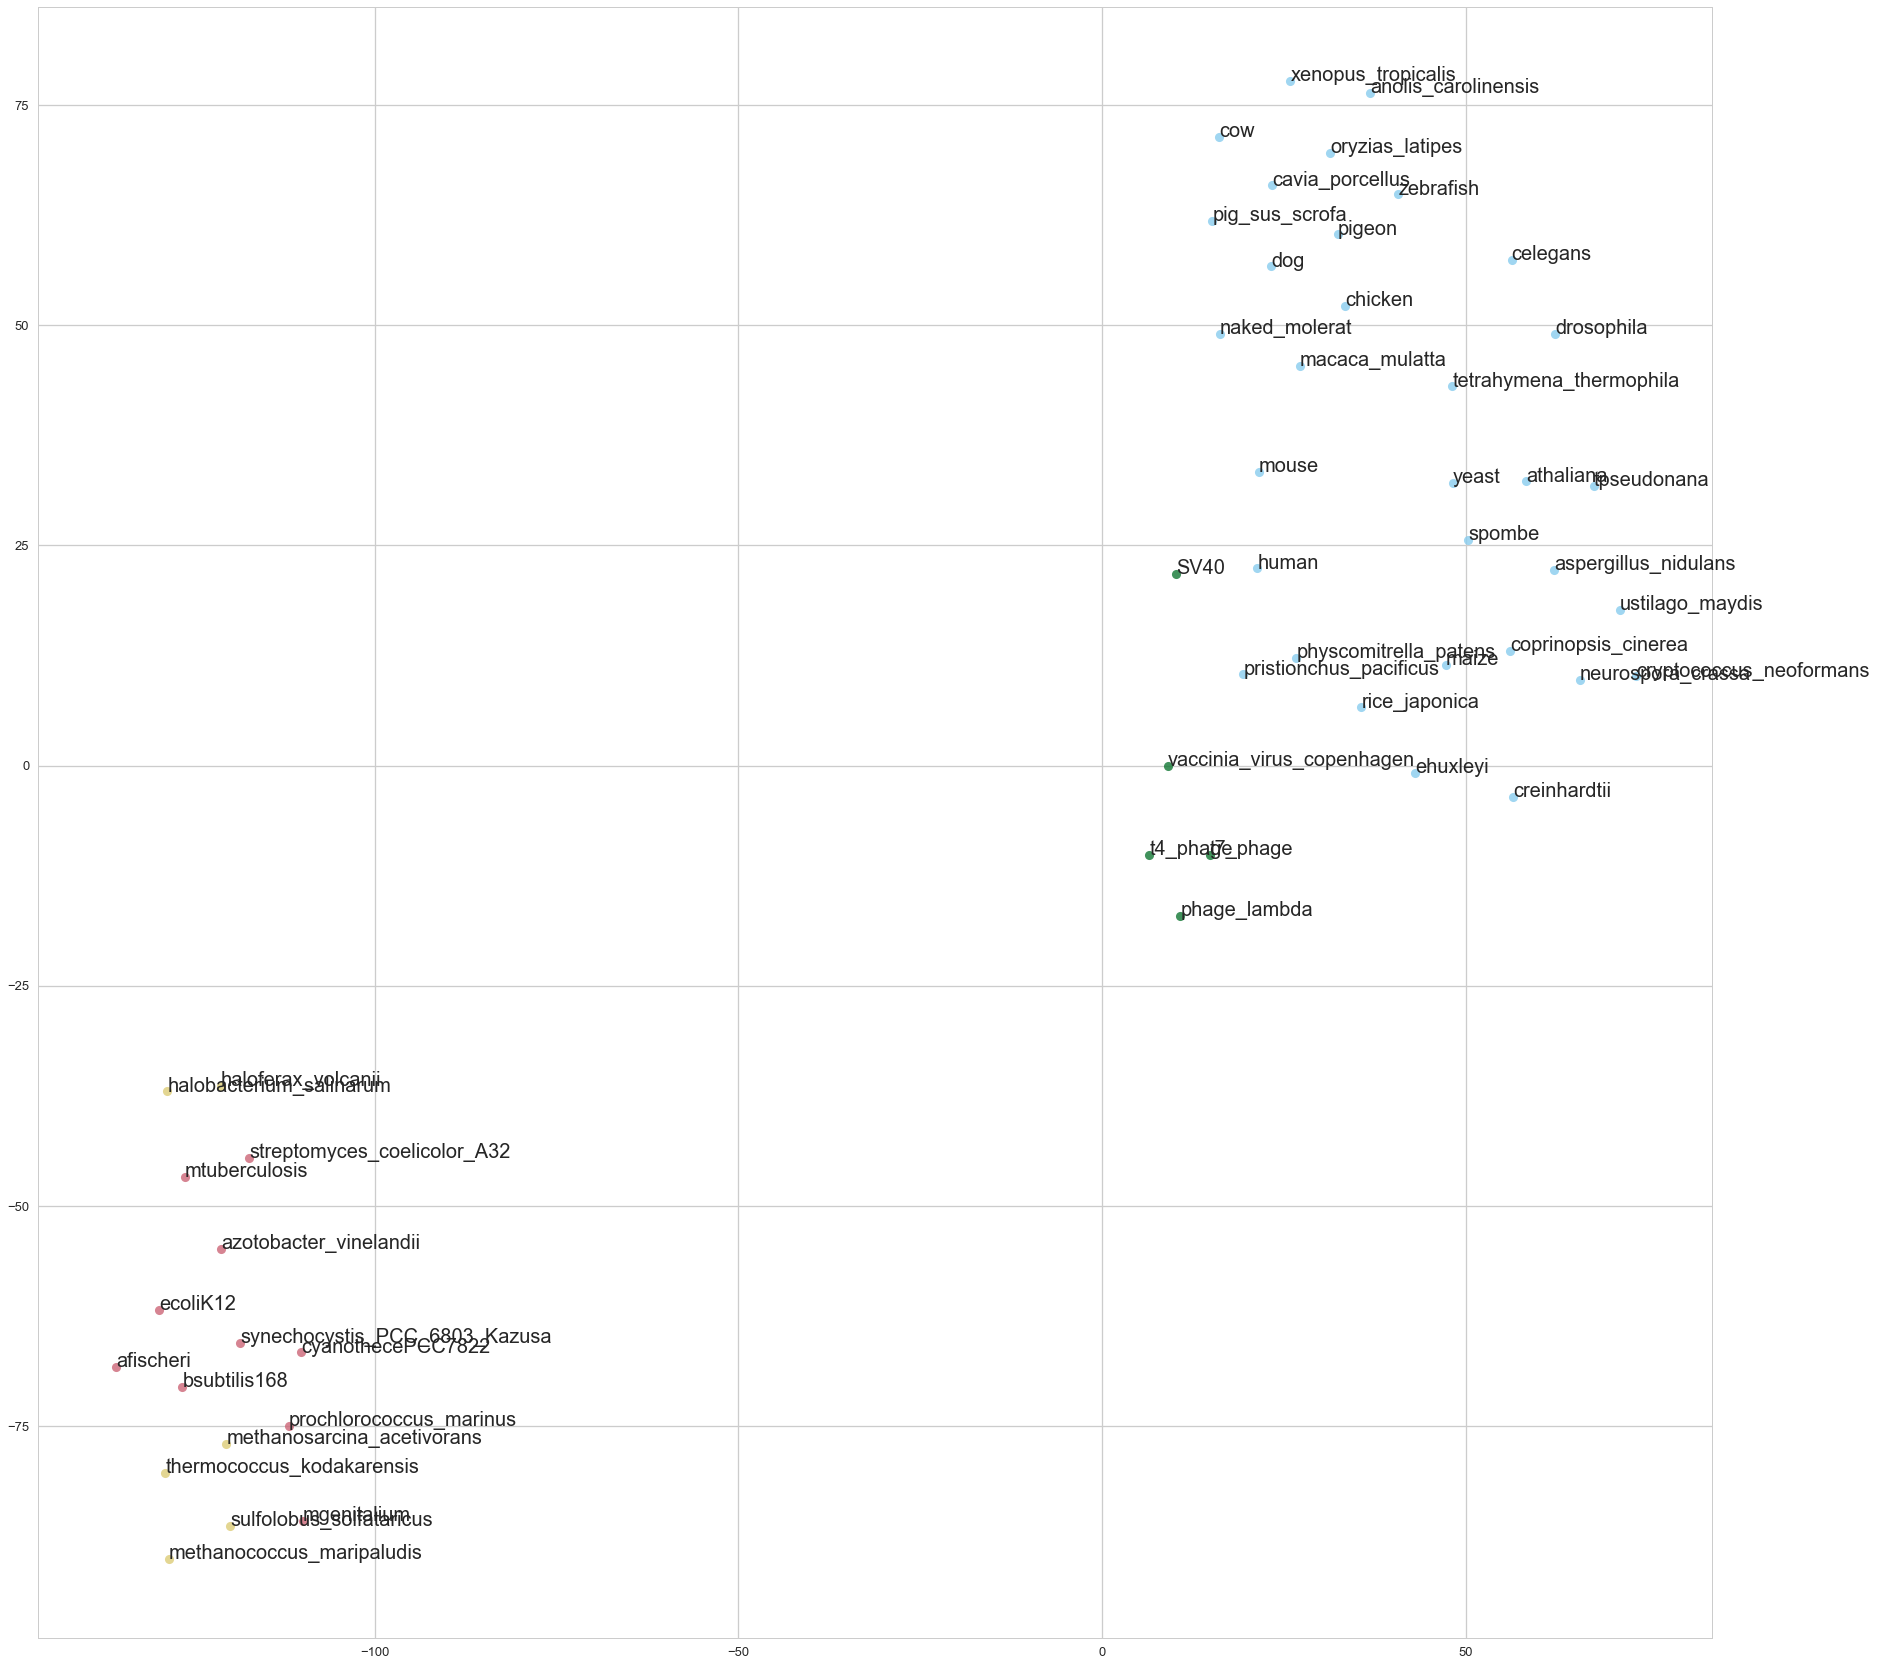

In [14]:
set_pub_plot_context()
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(111)
colors = sns.color_palette()
for i, name in enumerate(organism_means.domain.unique().tolist()):
    mask = organism_means.domain == name
    x = components[mask,0]
    y = components[mask,1]
    sns.regplot(x=x, y=y, fit_reg=False, ax=ax, color=colors[i])

x = components[:,0]
y = components[:,1]
label_point(pd.Series(x),pd.Series(y),
            pd.Series(organism_means.index.values)
            ,ax, fontsize=20)   

[]

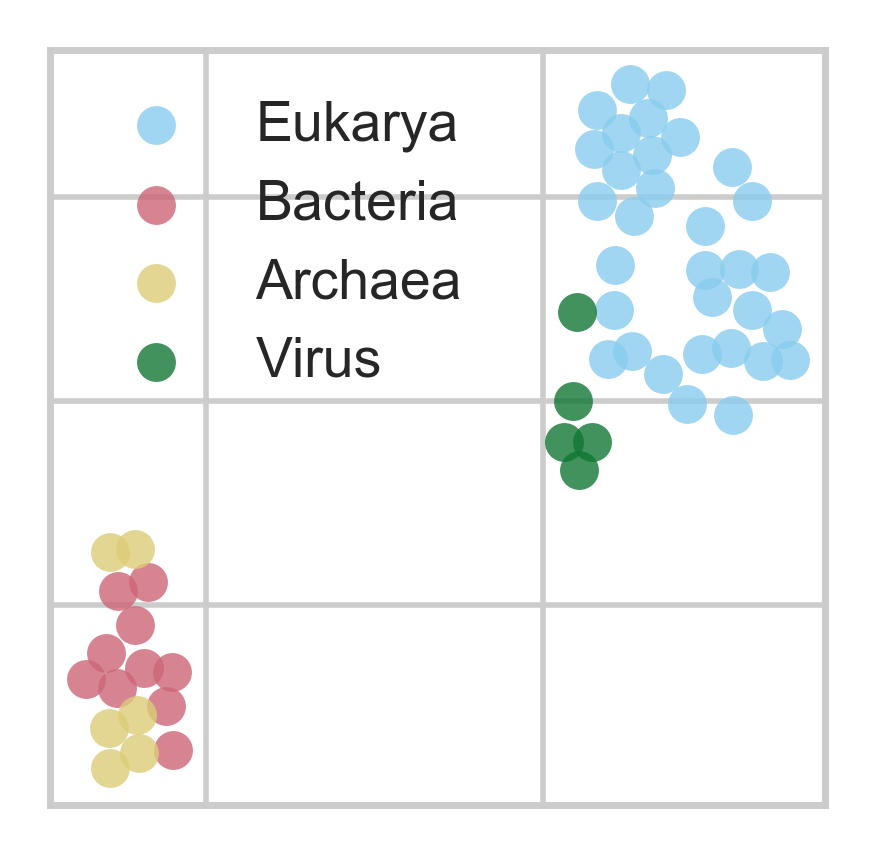

In [15]:
set_pub_plot_context(context="paper")
fig = plt.figure(figsize=(2,2), dpi=500)
ax = fig.add_subplot(111)
colors = sns.color_palette()
for i, name in enumerate(organism_means.domain.unique().tolist()):
    mask = organism_means.domain == name
    x = components[mask,0]
    y = components[mask,1]
    sns.regplot(x=x, y=y, fit_reg=False, ax=ax, color=colors[i], label=name)
    
ax.legend()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

[]

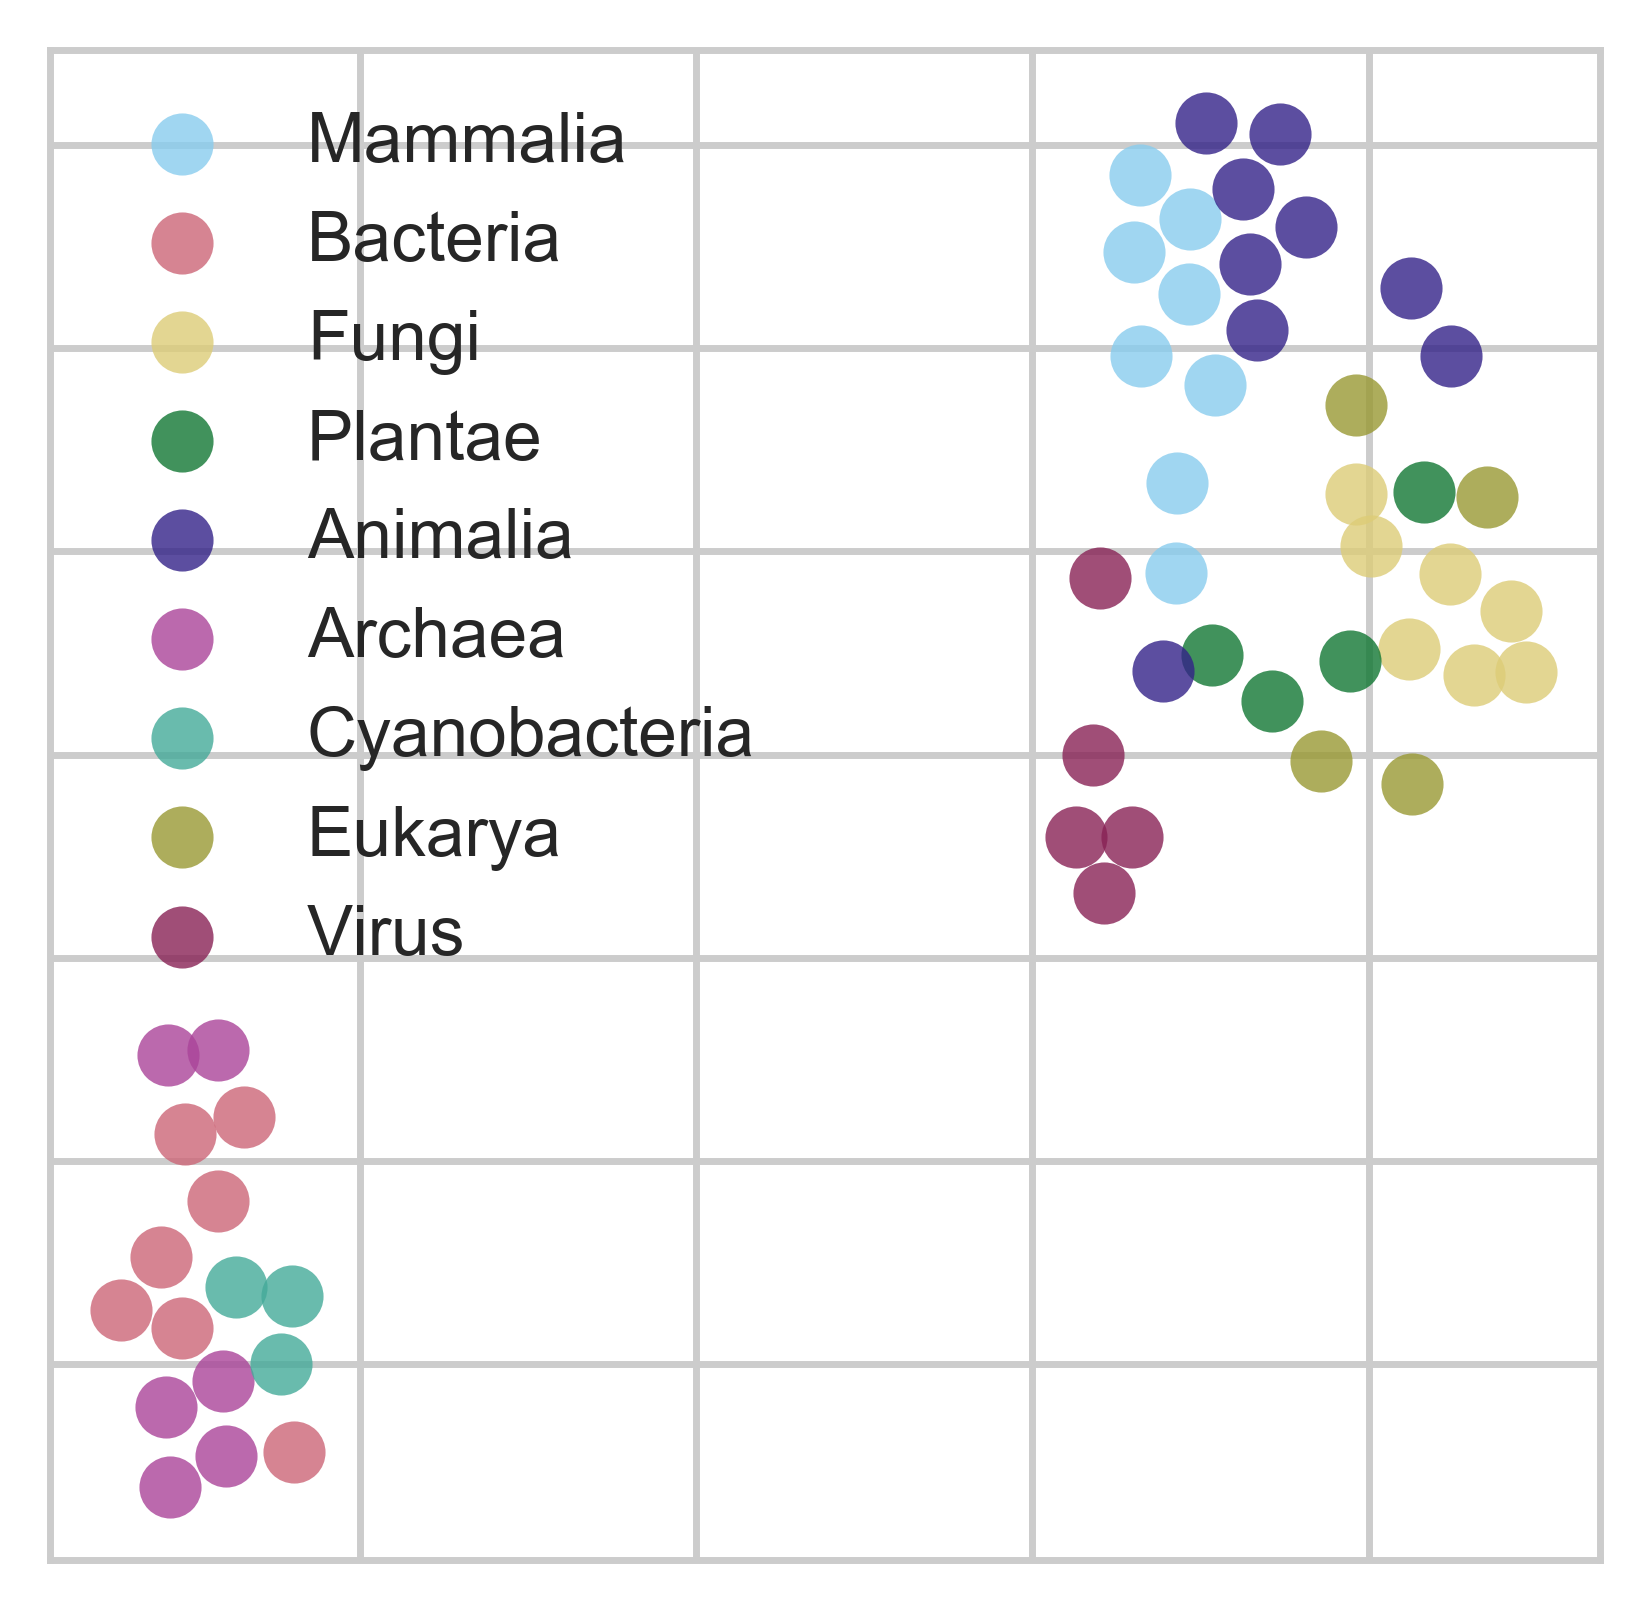

In [16]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(4,4), dpi=500)
ax = fig.add_subplot(111)
colors = sns.color_palette()
names = [ 'Mammalia','Bacteria', 'Fungi', 'Plantae', 'Animalia','Archaea',
       'Cyanobacteria', 'Eukarya', 'Virus']
for i, name in enumerate(names):
    mask = organism_means.specific_names == name
    x = components[mask,0]
    y = components[mask,1]
    sns.regplot(x=x, y=y, fit_reg=False, ax=ax, color=colors[i], label=name, scatter_kws={"s":80})
    
ax.legend()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

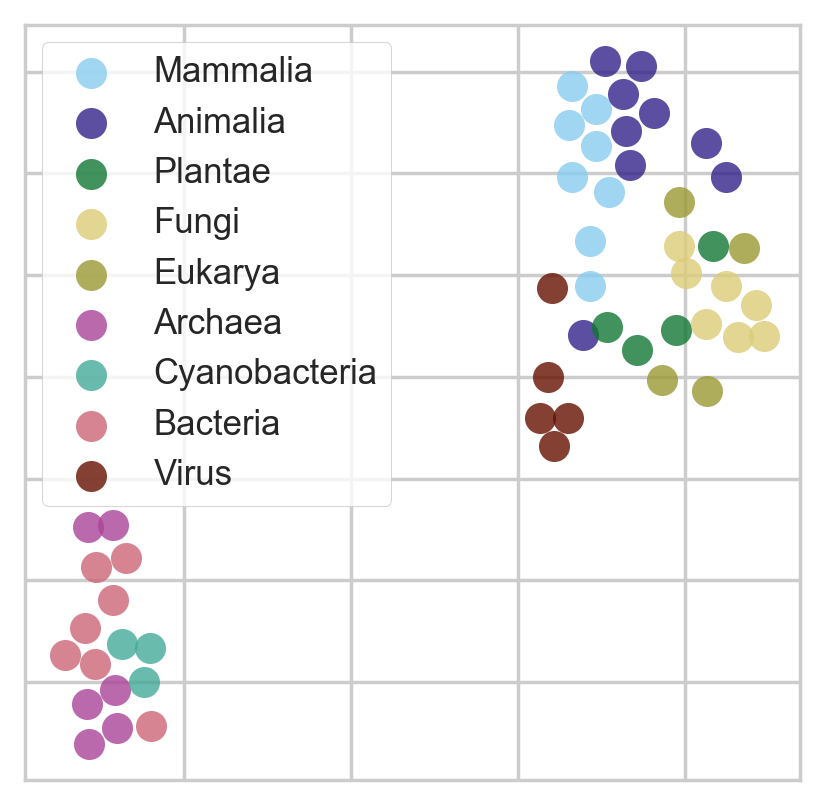

In [17]:
set_pub_plot_context(context="notebook")
fig = plt.figure(figsize=(4,4), dpi=250)
ax = fig.add_subplot(111)
colors = sns.color_palette()
names = ["Mammalia", "Animalia", 'Plantae', 'Fungi', 'Eukarya',
        'Archaea', 'Cyanobacteria', 'Bacteria', 'Virus'
        ]
# names = [ 'Mammalia','Bacteria', 'Fungi', 'Plantae', 'Animalia','Archaea',
#       'Cyanobacteria', 'Eukarya', 'Virus']
color_idxs = [0,4,3,2,7,5,6,1,9]
colors = [colors[i] for i in color_idxs]
for i, name in enumerate(names):
    mask = organism_means.specific_names == name
    x = components[mask,0]
    y = components[mask,1]
    sns.regplot(x=x, y=y, fit_reg=False, ax=ax, color=colors[i], label=name, scatter_kws={"s":80})
    
ax.legend(fancybox=True, frameon=True)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
save_for_pub(fig, path="./img/b", dpi=250)

In [18]:
organism_mean_full = organism_means.copy()

In [19]:
# Now do a PCA just with select model organisms
organism_means = organism_mean_full.loc[[
    "human", "yeast", "celegans", "drosophila", "zebrafish","mouse","athaliana", "macaca_mulatta", "dog", "spombe"
], :]
pca = PCA(n_components=4)
components = pca.fit_transform(
    organism_means.mean_rep.tolist()
)

In [20]:
organism_means

,mean_rep,domain,specific_names
organism,,,
human,"[0.0130582, -0.0374107, 0.0428389, -0.00578527...",Eukarya,Mammalia
yeast,"[0.00771811, -0.00860357, 0.0627896, -0.016818...",Eukarya,Fungi
celegans,"[0.009305, -0.0249642, 0.0590213, -0.0130596, ...",Eukarya,Animalia
drosophila,"[0.00918944, -0.0239516, 0.0533341, -0.0150933...",Eukarya,Animalia
zebrafish,"[0.0112134, -0.0351582, 0.0558743, -0.011223, ...",Eukarya,Animalia
mouse,"[0.0147409, -0.0370224, 0.0479789, -0.00780742...",Eukarya,Mammalia
athaliana,"[0.00912527, -0.0183137, 0.0587123, -0.0137392...",Eukarya,Plantae
macaca_mulatta,"[0.0103084, -0.031581, 0.0513376, -0.0115171, ...",Eukarya,Mammalia
dog,"[0.012644, -0.0302586, 0.053687, -0.0130803, -...",Eukarya,Mammalia


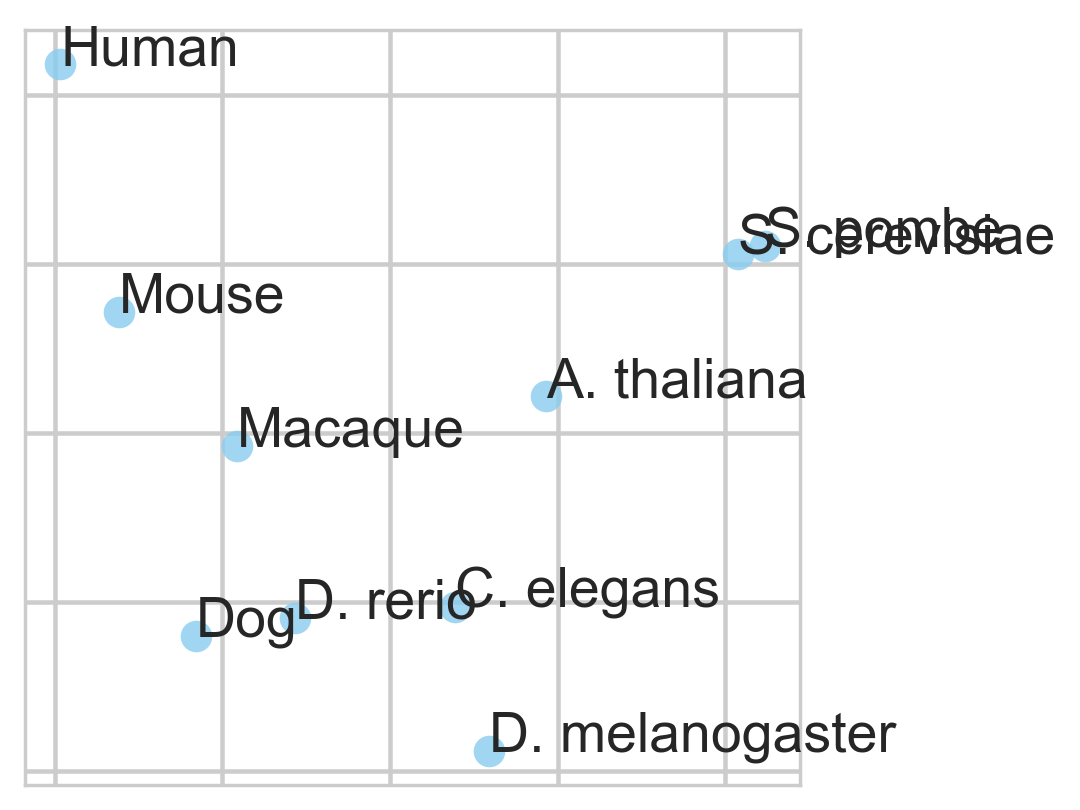

In [21]:
set_pub_plot_context()
fig = plt.figure(figsize=(4,4), dpi=250)
ax = fig.add_subplot(111)
x = components[:,0]
y = components[:,1]
sns.regplot(x=x, y=y, fit_reg=False, ax=ax)
pretty_names = ['Human', 'S. cerevisiae', 'C. elegans', 'D. melanogaster', 'D. rerio',
               'Mouse', 'A. thaliana', 'Macaque', 'Dog', 'S. pombe'
               ]
label_point(pd.Series(x- .02),pd.Series(y),
            pd.Series(pretty_names)
            ,ax, fontsize=16)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# Will edit colors and vectors in post
save_for_pub(fig, path="./img/suppS2_upper", dpi=250)

In [22]:
# Save this one too
pickle.dump(pca, open("../../data/models3_only_organism_pca.pkl", "wb"))